# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 


The [rubric](https://review.udacity.com/#!/rubrics/481/view)


In [1]:
# Imports
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

In [ ]:
## Aux layers  
def conv2d_batch_norm(*args, **kwargs):

    activation = kwargs.pop("activation", None)
    batch_norm = kwargs.pop("batch_norm", {})

    net = tf.layers.conv2d(*args, **kwargs)
    net = tf.layers.batch_normalization(net, **batch_norm)

    return activation(net) if activation else net

def dense_batch_norm(*args, **kwargs):

    activation = kwargs.pop("activation", None)
    batch_norm = kwargs.pop("batch_norm", {})

    net = tf.layers.dense(*args, **kwargs)
    net = tf.layers.batch_normalization(net, **batch_norm)

    return activation(net) if activation else net

In [68]:
# Capa Convolucional: 16 filtros, kernel 5x5, padding 'same', funcion de activacion ELU
# Capa Convolucional: 32 filtros, kernel 3x3, padding 'same', stride 2, funcion de activacion ELU
# Capa Convolucional: 64 filtros, kernel 3x3, padding 'same', stride 2, funcion de activacion ELU
# Capa Convolucional: 64 filtros, kernel 3x3, padding 'same', funcion de activacion ELU
# Flatten: se aplana a vector
# Capa Densa: 1024 neuronas, activacion ELU, dropout = 0.5
# Capa Densa: 512 neuronas, activacion ELU
# Capa Densa Output: 43 neuronal, activacion softmax
mu = 0
sigma = 0.1
init = None #tf.initializers.truncated_normal(mean = mu, stddev = sigma)


def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 32, 32, 3])

    general_ops = dict(
#         activation = activation,
        batch_norm = dict(training = mode == tf.estimator.ModeKeys.TRAIN)
#         kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_regularization),
    )
    
    # Convolutional Layer #1
    conv1 = conv2d_batch_norm(
      inputs=input_layer,
      filters=16,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu, kernel_initializer=init,
      **general_ops)
    
    # Convolutional Layer #2
    conv2 = conv2d_batch_norm(
      inputs=conv1,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu, kernel_initializer=init,
    **general_ops)
    
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Convolutional Layer #3 and Pooling Layer #2
    conv3 = conv2d_batch_norm(
      inputs=pool1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu, kernel_initializer=init,
    **general_ops)

    pool2 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #4 and Pooling Layer #2
    conv4 = conv2d_batch_norm(
      inputs=pool2,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu, kernel_initializer=init,
    **general_ops)

    # Dense Layers
    pool2_flat = tf.layers.flatten(conv4)
    
    dense1 = dense_batch_norm(inputs=pool2_flat,
                             units=1024,
                             activation=tf.nn.relu,
                             kernel_initializer=init,
                             **general_ops)
    dense1 = tf.layers.dropout(
      inputs=dense1, rate=0.5, training= mode == tf.estimator.ModeKeys.TRAIN)
    
    dense2 = dense_batch_norm(inputs=dense1,
                              units=512,
                              activation=tf.nn.relu,
                              kernel_initializer=init,
                             **general_ops)

    # Logits Layer
    logits = tf.layers.dense(inputs=dense2, units=43, kernel_initializer=init)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }


    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    with tf.name_scope('loss'):
            loss = tf.losses.sparse_softmax_cross_entropy(
                labels=labels, logits=logits, scope='loss')
            tf.summary.scalar('loss', loss)
    
    # Accuracy    
    with tf.name_scope('accuracy'):
            accuracy = tf.metrics.accuracy(
                labels=labels, predictions=predictions["classes"], name='acc')
            tf.summary.scalar('accuracy', accuracy[1])

    # Create a hook to print acc, loss & global step every 100 iter.   
    train_hook_list= []
    train_tensors_log = {'accuracy': accuracy[1],
                         'loss': loss}
    train_hook_list.append(tf.train.LoggingTensorHook(
        tensors=train_tensors_log, every_n_iter=100))

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#             optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
#             optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
            optimizer = tf.train.AdagradOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(
                loss=loss,
                global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(
                mode=mode, 
                loss=loss, 
                train_op=train_op, 
                training_hooks=train_hook_list)

    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops={'accuracy/accuracy': accuracy}, evaluation_hooks=None)

In [69]:
# Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/traffic_convnet_model1_6")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_experimental_distribute': None, '_task_id': 0, '_train_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f01480c3550>, '_save_summary_steps': 100, '_tf_random_seed': None, '_is_chief': True, '_keep_checkpoint_max': 5, '_evaluation_master': '', '_model_dir': '/tmp/traffic_convnet_model1_6', '_master': '', '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_service': None, '_eval_distribute': None, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_protocol': None}


In [70]:
# # Set up logging for predictions
# tensors_to_log = {"accuracy": "accuracy"}
# logging_hook = tf.train.LoggingTensorHook(
#     tensors=tensors_to_log, every_n_iter=50)

In [71]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": np.array(X_train, dtype=np.float32)},
    y=np.array(y_train, dtype=np.int32),
    batch_size=128,
    num_epochs=1,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": np.array(X_valid, dtype=np.float32)},
        y=np.array(y_valid, dtype=np.int32),
        num_epochs=1,
        shuffle=False)

# classifier.train(
#     input_fn=train_input_fn,
#     steps=None,
#     hooks=[logging_hook])

In [ ]:
train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn)

for i in range(120*6):
    print("\n\n******* EPOCH: {} **************".format(i+1))
    tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)



******* EPOCH: 1 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 4.2516937, step = 0
INFO:tensorflow:accuracy = 0.0, loss = 4.2516937
INFO:tensorflow:global_step/sec: 66.8044
INFO:tensorflow:loss = 3.0354419, step = 100 (1.499 sec)
INFO:tensorflow:accuracy = 0.171875, loss = 3.0354419 (1.499 sec)
INFO:tensorflow:global_step/sec: 73.7202


INFO:tensorflow:Loss for final step: 0.7206748.


******* EPOCH: 5 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-1088
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1088 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 2.6429253, step = 1088
INFO:tensorflow:accuracy = 0.15625, loss = 2.6429253
INFO:tensorflow:global_step/sec: 68.1504
INFO:tensorflow:lo

INFO:tensorflow:Saving dict for global step 2176: accuracy/accuracy = 0.35442176, global_step = 2176, loss = 2.473151
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2176: /tmp/traffic_convnet_model1_6/model.ckpt-2176
INFO:tensorflow:Loss for final step: 0.15729454.


******* EPOCH: 9 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-2176
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorfl

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-22:56:02
INFO:tensorflow:Saving dict for global step 3264: accuracy/accuracy = 0.46893424, global_step = 3264, loss = 2.116671
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3264: /tmp/traffic_convnet_model1_6/model.ckpt-3264
INFO:tensorflow:Loss for final step: 0.13481493.


******* EPOCH: 13 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflo

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-22:56:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-4352
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-22:56:28
INFO:tensorflow:Saving dict for global step 4352: accuracy/accuracy = 0.54240364, global_step = 4352, loss = 1.71452
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4352: /tmp/traffic_convnet_model1_6/model.ckpt-4352
INFO:tensorflow:Loss for final step: 0.25047645.


******* EPOCH: 17 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The

INFO:tensorflow:global_step/sec: 71.3151
INFO:tensorflow:loss = 0.33780706, step = 5368 (1.402 sec)
INFO:tensorflow:accuracy = 0.9140625, loss = 0.33780706 (1.403 sec)
INFO:tensorflow:Saving checkpoints for 5440 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-22:56:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-5440
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-22:56:54
INFO:tensorflow:Saving dict for global step 5440: accuracy/accuracy = 0.5972789, global_step = 5440, loss = 1.4209365
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5440: /tmp/traffic_convnet_model1_6/model.ckpt-5440

INFO:tensorflow:accuracy = 0.9375, loss = 0.38677013
INFO:tensorflow:global_step/sec: 66.3436
INFO:tensorflow:loss = 0.15751311, step = 6356 (1.508 sec)
INFO:tensorflow:accuracy = 0.953125, loss = 0.15751311 (1.508 sec)
INFO:tensorflow:global_step/sec: 72.0632
INFO:tensorflow:loss = 0.3261283, step = 6456 (1.388 sec)
INFO:tensorflow:accuracy = 0.953125, loss = 0.3261283 (1.388 sec)
INFO:tensorflow:Saving checkpoints for 6528 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-22:57:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-6528
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-22:57:20
INFO:tensorflow:S

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7344 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.966864, step = 7344
INFO:tensorflow:accuracy = 0.640625, loss = 0.966864
INFO:tensorflow:global_step/sec: 68.1137
INFO:tensorflow:loss = 0.21498509, step = 7444 (1.469 sec)
INFO:tensorflow:accuracy = 0.79296875, loss = 0.21498509 (1.469 sec)
INFO:tensorflow:global_step/sec: 71.9122
INFO:tensorflow:loss = 0.04505486, step = 7544 (1.390 sec)
INFO:tensorflow:accuracy = 0.859375, loss = 0.04505486 (1.391 sec)
INFO:tensorflow:Saving checkpoints for 7616 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-22:57:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-7616
INFO:tensorflow:Running local_init_op.
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-8432
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8432 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.13967934, step = 8432
INFO:tensorflow:accuracy = 0.953125, loss = 0.13967934
INFO:tensorflow:global_step/sec: 63.9414
INFO:tensorflow:loss = 0.090711266, step = 8532 (1.565 sec)
INFO:tensorflow:accuracy = 0.96875, loss = 0.090711266 (1.565 sec)
INFO:tensorflow:global_step/sec: 66.134
INFO:tensorflow:loss = 0.21066815, step = 8632 (1.512 sec)
INFO:tensorflow:accuracy = 0.9661458, loss = 0.21066815 (1.512 sec)
INFO:tensorflow:Saving checkpoints for 8704 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done c

INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-9520
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9520 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.104504816, step = 9520
INFO:tensorflow:accuracy = 0.9765625, loss = 0.104504816
INFO:tensorflow:global_step/sec: 67.6812
INFO:tensorflow:loss = 0.1621506, step = 9620 (1.479 sec)
INFO:tensorflow:accuracy = 0.9765625, loss = 0.1621506 (1.479 sec)
INFO:tensorflow:global_step/sec: 72.6923
INFO:tensorflow:loss = 0.13481763, step = 9720 (1.375

INFO:tensorflow:Loss for final step: 0.014397939.


******* EPOCH: 40 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-10608
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 10608 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.032261156, step = 10608
INFO:tensorflow:accuracy = 0.9921875, loss = 0.032261156
INFO:tensorflow:global_step/sec: 68.065
INFO:te

INFO:tensorflow:Finished evaluation at 2019-01-16-22:59:22
INFO:tensorflow:Saving dict for global step 11696: accuracy/accuracy = 0.8115646, global_step = 11696, loss = 0.65758455
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11696: /tmp/traffic_convnet_model1_6/model.ckpt-11696
INFO:tensorflow:Loss for final step: 0.11729211.


******* EPOCH: 44 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-11696
INFO:tensorflow:Running local_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-12784
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-22:59:48
INFO:tensorflow:Saving dict for global step 12784: accuracy/accuracy = 0.82471657, global_step = 12784, loss = 0.6183462
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12784: /tmp/traffic_convnet_model1_6/model.ckpt-12784
INFO:tensorflow:Loss for final step: 0.08230867.


******* EPOCH: 48 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoin

INFO:tensorflow:accuracy = 0.9739583, loss = 0.093937814 (1.395 sec)
INFO:tensorflow:Saving checkpoints for 13872 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:00:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-13872
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:00:14
INFO:tensorflow:Saving dict for global step 13872: accuracy/accuracy = 0.8267574, global_step = 13872, loss = 0.59809506
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13872: /tmp/traffic_convnet_model1_6/model.ckpt-13872
INFO:tensorflow:Loss for final step: 0.045390308.


******* EPOCH: 52 **************
INFO:t

INFO:tensorflow:global_step/sec: 67.5116
INFO:tensorflow:loss = 0.14601609, step = 14788 (1.482 sec)
INFO:tensorflow:accuracy = 0.96484375, loss = 0.14601609 (1.482 sec)
INFO:tensorflow:global_step/sec: 73.4065
INFO:tensorflow:loss = 0.07269546, step = 14888 (1.363 sec)
INFO:tensorflow:accuracy = 0.96875, loss = 0.07269546 (1.363 sec)
INFO:tensorflow:Saving checkpoints for 14960 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:00:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-14960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:00:40
INFO:tensorflow:Saving dict for global step 14960: accuracy/acc

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 15776 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.06377548, step = 15776
INFO:tensorflow:accuracy = 0.9765625, loss = 0.06377548
INFO:tensorflow:global_step/sec: 68.5263
INFO:tensorflow:loss = 0.05380425, step = 15876 (1.461 sec)
INFO:tensorflow:accuracy = 0.98828125, loss = 0.05380425 (1.460 sec)
INFO:tensorflow:global_step/sec: 74.2859
INFO:tensorflow:loss = 0.027991902, step = 15976 (1.346 sec)
INFO:tensorflow:accuracy = 0.9895833, loss = 0.027991902 (1.346 sec)
INFO:tensorflow:Saving checkpoints for 16048 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:01:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-16048
INFO:tensorflow:Running local_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-16864
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 16864 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.13681924, step = 16864
INFO:tensorflow:accuracy = 0.984375, loss = 0.13681924
INFO:tensorflow:global_step/sec: 68.318
INFO:tensorflow:loss = 0.03160374, step = 16964 (1.465 sec)
INFO:tensorflow:accuracy = 0.98828125, loss = 0.03160374 (1.464 sec)
INFO:tensorflow:global_step/sec: 73.2804
INFO:tensorflow:loss = 0.09104537, step = 17064 (1.365 sec)
INFO:tensorflow:accuracy = 0.9895833, loss = 0.09104537 (1.365 sec)
INFO:tensorflow:Saving checkpoints for 17136 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-17952
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 17952 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.011260791, step = 17952
INFO:tensorflow:accuracy = 1.0, loss = 0.011260791
INFO:tensorflow:global_step/sec: 66.9748
INFO:tensorflow:loss = 0.02421504, step = 18052 (1.494 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.02421504 (1.494 sec)
INFO:tensorflow:global_st

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 19040: /tmp/traffic_convnet_model1_6/model.ckpt-19040
INFO:tensorflow:Loss for final step: 0.03360852.


******* EPOCH: 71 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-19040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 19040 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.032437064,

INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:02:44
INFO:tensorflow:Saving dict for global step 20128: accuracy/accuracy = 0.8839002, global_step = 20128, loss = 0.34477344
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20128: /tmp/traffic_convnet_model1_6/model.ckpt-20128
INFO:tensorflow:Loss for final step: 0.048470844.


******* EPOCH: 75 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tenso

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:03:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-21216
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:03:10
INFO:tensorflow:Saving dict for global step 21216: accuracy/accuracy = 0.8839002, global_step = 21216, loss = 0.36411783
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21216: /tmp/traffic_convnet_model1_6/model.ckpt-21216
INFO:tensorflow:Loss for final step: 0.0045672073.


******* EPOCH: 79 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen aft

INFO:tensorflow:global_step/sec: 70.8595
INFO:tensorflow:loss = 0.038566746, step = 22232 (1.412 sec)
INFO:tensorflow:accuracy = 0.9635417, loss = 0.038566746 (1.412 sec)
INFO:tensorflow:Saving checkpoints for 22304 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:03:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-22304
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:03:36
INFO:tensorflow:Saving dict for global step 22304: accuracy/accuracy = 0.88843536, global_step = 22304, loss = 0.34749302
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 22304: /tmp/traffic_convnet_model1_6/model

INFO:tensorflow:loss = 0.004857268, step = 23120
INFO:tensorflow:accuracy = 1.0, loss = 0.004857268
INFO:tensorflow:global_step/sec: 66.0698
INFO:tensorflow:loss = 0.05005228, step = 23220 (1.515 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.05005228 (1.515 sec)
INFO:tensorflow:global_step/sec: 70.566
INFO:tensorflow:loss = 0.042421695, step = 23320 (1.417 sec)
INFO:tensorflow:accuracy = 0.9973958, loss = 0.042421695 (1.417 sec)
INFO:tensorflow:Saving checkpoints for 23392 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:04:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-23392
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished e

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-24208
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 24208 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.04439584, step = 24208
INFO:tensorflow:accuracy = 0.9921875, loss = 0.04439584
INFO:tensorflow:global_step/sec: 66.1285
INFO:tensorflow:loss = 0.039620668, step = 24308 (1.513 sec)
INFO:tensorflow:accuracy = 0.9921875, loss = 0.039620668 (1.513 sec)
INFO:tensorflow:global_step/sec: 70.0679
INFO:tensorflow:loss = 0.026644524, step = 24408 (1.427 sec)
INFO:tensorflow:accuracy = 0.9921875, loss = 0.026644524 (1.427 sec)
INFO:tensorflow:Saving checkpoints for 24480 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:04:28
INFO:tensorflow:Graph was fin

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-25296
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 25296 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.9406499, step = 25296
INFO:tensorflow:accuracy = 0.6015625, loss = 0.9406499
INFO:tensorflow:global_step/sec: 65.9367
INFO:tensorflow:loss = 0.06636183, step = 25396 (1.518 sec)
INFO:tensorflow:accuracy = 0.7890625, loss = 0.06636183 (1.518 sec)
INFO:tensorflow:global_step/sec: 73.5732
INFO:tensorflow:loss = 0.066594034, step = 25496 (1.359 sec)
INFO:tensorflow:accuracy = 0.8515625, loss = 0.066594034 (1.359 sec)
INFO:tensorflow:Saving checkpoints for 25568 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflo

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-26384
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 26384 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.021604845, step = 26384
INFO:tensorflow:accuracy = 1.0, loss = 0.021604845
INFO:tensorflow:global_step/sec: 68.5896
INFO:tensorflow:loss = 0.05650073, step = 26484 (1.459 sec)
INFO:tensorflow:accuracy = 0.99609375, loss = 0.05650073 (1.459 sec)
INFO:tensorflow:gl

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27472: /tmp/traffic_convnet_model1_6/model.ckpt-27472
INFO:tensorflow:Loss for final step: 0.06461545.


******* EPOCH: 102 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-27472
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 27472 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.04029525,

INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:06:06
INFO:tensorflow:Saving dict for global step 28560: accuracy/accuracy = 0.9111111, global_step = 28560, loss = 0.26759368
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 28560: /tmp/traffic_convnet_model1_6/model.ckpt-28560
INFO:tensorflow:Loss for final step: 0.02592912.


******* EPOCH: 106 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tenso

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:06:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-29648
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:06:32
INFO:tensorflow:Saving dict for global step 29648: accuracy/accuracy = 0.9099773, global_step = 29648, loss = 0.28351936
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 29648: /tmp/traffic_convnet_model1_6/model.ckpt-29648
INFO:tensorflow:Loss for final step: 0.0835814.


******* EPOCH: 110 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after

INFO:tensorflow:global_step/sec: 72.9885
INFO:tensorflow:loss = 0.03998261, step = 30664 (1.370 sec)
INFO:tensorflow:accuracy = 0.9869792, loss = 0.03998261 (1.370 sec)
INFO:tensorflow:Saving checkpoints for 30736 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:06:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-30736
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:06:58
INFO:tensorflow:Saving dict for global step 30736: accuracy/accuracy = 0.9047619, global_step = 30736, loss = 0.2958868
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30736: /tmp/traffic_convnet_model1_6/model.ckp

INFO:tensorflow:loss = 0.07576267, step = 31552
INFO:tensorflow:accuracy = 0.9765625, loss = 0.07576267
INFO:tensorflow:global_step/sec: 64.4367
INFO:tensorflow:loss = 0.009252932, step = 31652 (1.553 sec)
INFO:tensorflow:accuracy = 0.98828125, loss = 0.009252932 (1.553 sec)
INFO:tensorflow:global_step/sec: 72.4774
INFO:tensorflow:loss = 0.031683847, step = 31752 (1.380 sec)
INFO:tensorflow:accuracy = 0.9869792, loss = 0.031683847 (1.380 sec)
INFO:tensorflow:Saving checkpoints for 31824 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:07:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-31824
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorf

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-32640
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 32640 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.33757964, step = 32640
INFO:tensorflow:accuracy = 0.8984375, loss = 0.33757964
INFO:tensorflow:global_step/sec: 66.359
INFO:tensorflow:loss = 0.015497178, step = 32740 (1.508 sec)
INFO:tensorflow:accuracy = 0.9453125, loss = 0.015497178 (1.508 sec)
INFO:tensorflow:global_step/sec: 72.0297
INFO:tensorflow:loss = 0.051204257, step = 32840 (1.388 sec)
INFO:tensorflow:accuracy = 0.9583333, loss = 0.051204257 (1.388 sec)
INFO:tensorflow:Saving checkpoints for 32912 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:07:49
INFO:tensorflow:Graph was fina

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-33728
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 33728 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.030523283, step = 33728
INFO:tensorflow:accuracy = 1.0, loss = 0.030523283
INFO:tensorflow:global_step/sec: 65.3216
INFO:tensorflow:loss = 0.013212315, step = 33828 (1.532 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.013212315 (1.532 sec)
INFO:tensorflow:global_step/sec: 70.4328
INFO:tensorflow:loss = 0.030688956, step = 33928 (1.420 sec)
INFO:tensorflow:accuracy = 0.9973958, loss = 0.030688956 (1.420 sec)
INFO:tensorflow:Saving checkpoints for 34000 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-34816
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 34816 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.00863376, step = 34816
INFO:tensorflow:accuracy = 1.0, loss = 0.00863376
INFO:tensorflow:global_step/sec: 62.4934
INFO:tensorflow:loss = 0.0135840075, step = 34916 (1.601 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0135840075 (1.601 sec)
INFO:tensorflow:global_

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 35904: /tmp/traffic_convnet_model1_6/model.ckpt-35904
INFO:tensorflow:Loss for final step: 0.021972407.


******* EPOCH: 133 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-35904
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 35904 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.02725773

INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:09:28
INFO:tensorflow:Saving dict for global step 36992: accuracy/accuracy = 0.91882086, global_step = 36992, loss = 0.2574814
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 36992: /tmp/traffic_convnet_model1_6/model.ckpt-36992
INFO:tensorflow:Loss for final step: 0.010803442.


******* EPOCH: 137 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tens

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:09:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-38080
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:09:53
INFO:tensorflow:Saving dict for global step 38080: accuracy/accuracy = 0.9160998, global_step = 38080, loss = 0.2504581
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 38080: /tmp/traffic_convnet_model1_6/model.ckpt-38080
INFO:tensorflow:Loss for final step: 0.01952884.


******* EPOCH: 141 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after

INFO:tensorflow:global_step/sec: 72.9359
INFO:tensorflow:loss = 0.059213743, step = 39096 (1.370 sec)
INFO:tensorflow:accuracy = 0.9947917, loss = 0.059213743 (1.370 sec)
INFO:tensorflow:Saving checkpoints for 39168 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:10:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-39168
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:10:19
INFO:tensorflow:Saving dict for global step 39168: accuracy/accuracy = 0.92199546, global_step = 39168, loss = 0.2435845
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 39168: /tmp/traffic_convnet_model1_6/model.

INFO:tensorflow:loss = 0.032690853, step = 39984
INFO:tensorflow:accuracy = 0.9921875, loss = 0.032690853
INFO:tensorflow:global_step/sec: 68.7609
INFO:tensorflow:loss = 0.029757205, step = 40084 (1.455 sec)
INFO:tensorflow:accuracy = 0.99609375, loss = 0.029757205 (1.455 sec)
INFO:tensorflow:global_step/sec: 73.296
INFO:tensorflow:loss = 0.016720826, step = 40184 (1.364 sec)
INFO:tensorflow:accuracy = 0.9973958, loss = 0.016720826 (1.365 sec)
INFO:tensorflow:Saving checkpoints for 40256 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:10:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-40256
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensor

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-41072
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 41072 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.05059611, step = 41072
INFO:tensorflow:accuracy = 0.984375, loss = 0.05059611
INFO:tensorflow:global_step/sec: 65.8538
INFO:tensorflow:loss = 0.02457465, step = 41172 (1.521 sec)
INFO:tensorflow:accuracy = 0.9921875, loss = 0.02457465 (1.521 sec)
INFO:tensorflow:global_step/sec: 70.3397
INFO:tensorflow:loss = 0.026251316, step = 41272 (1.420 sec)
INFO:tensorflow:accuracy = 0.9921875, loss = 0.026251316 (1.420 sec)
INFO:tensorflow:Saving checkpoints for 41344 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:11:10
INFO:tensorflow:Graph was finali

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-42160
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 42160 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.0050147534, step = 42160
INFO:tensorflow:accuracy = 1.0, loss = 0.0050147534
INFO:tensorflow:global_step/sec: 62.9509
INFO:tensorflow:loss = 0.0077789463, step = 42260 (1.590 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0077789463 (1.590 sec)
INFO:tensorflow:global_step/sec: 68.3339
INFO:tensorflow:loss = 0.010062332, step = 42360 (1.464 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.010062332 (1.464 sec)
INFO:tensorflow:Saving checkpoints for 42432 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done c

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-43248
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 43248 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.032227628, step = 43248
INFO:tensorflow:accuracy = 0.9921875, loss = 0.032227628
INFO:tensorflow:global_step/sec: 65.685
INFO:tensorflow:loss = 0.006902213, step = 43348 (1.523 sec)
INFO:tensorflow:accuracy = 0.99609375, loss = 0.006902213 (1.524 sec)
INFO:tensor

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 44336: /tmp/traffic_convnet_model1_6/model.ckpt-44336
INFO:tensorflow:Loss for final step: 0.015322356.


******* EPOCH: 164 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-44336
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 44336 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.02311583

INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:12:47
INFO:tensorflow:Saving dict for global step 45424: accuracy/accuracy = 0.9215419, global_step = 45424, loss = 0.24691066
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 45424: /tmp/traffic_convnet_model1_6/model.ckpt-45424
INFO:tensorflow:Loss for final step: 0.011606681.


******* EPOCH: 168 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tens

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:13:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-46512
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:13:13
INFO:tensorflow:Saving dict for global step 46512: accuracy/accuracy = 0.9276644, global_step = 46512, loss = 0.2242534
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 46512: /tmp/traffic_convnet_model1_6/model.ckpt-46512
INFO:tensorflow:Loss for final step: 0.019037599.


******* EPOCH: 172 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen afte

INFO:tensorflow:global_step/sec: 74.6664
INFO:tensorflow:loss = 0.014454717, step = 47528 (1.339 sec)
INFO:tensorflow:accuracy = 0.9973958, loss = 0.014454717 (1.339 sec)
INFO:tensorflow:Saving checkpoints for 47600 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:13:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-47600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:13:38
INFO:tensorflow:Saving dict for global step 47600: accuracy/accuracy = 0.92925173, global_step = 47600, loss = 0.21937549
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 47600: /tmp/traffic_convnet_model1_6/model

INFO:tensorflow:loss = 0.015202941, step = 48416
INFO:tensorflow:accuracy = 1.0, loss = 0.015202941
INFO:tensorflow:global_step/sec: 68.8612
INFO:tensorflow:loss = 0.011810854, step = 48516 (1.453 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.011810854 (1.453 sec)
INFO:tensorflow:global_step/sec: 74.3718
INFO:tensorflow:loss = 0.020797785, step = 48616 (1.345 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.020797785 (1.345 sec)
INFO:tensorflow:Saving checkpoints for 48688 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:14:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-48688
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished eval

INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-49504
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 49504 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.007097263, step = 49504
INFO:tensorflow:accuracy = 1.0, loss = 0.007097263
INFO:tensorflow:global_step/sec: 69.1171
INFO:tensorflow:loss = 0.0081308475, step = 49604 (1.448 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0081308475 (1.447 sec)
INFO:tensorflow:global_step/sec: 74.6097
INFO:tensorflow:loss = 0.02824512, step = 49704 (1.341 sec)
INFO:tensorflow:accuracy = 0.9973958, loss = 0.02824512 (1.341 sec)
INFO:tensorflow:Saving checkpoints for 49776 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:14:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters fr

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-50592
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50592 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.021103863, step = 50592
INFO:tensorflow:accuracy = 0.9921875, loss = 0.021103863
INFO:tensorflow:global_step/sec: 63.3817
INFO:tensorflow:loss = 0.005407638, step = 50692 (1.579 sec)
INFO:tensorflow:accuracy = 0.99609375, loss = 0.005407638 (1.579 sec)
INFO:tensorflow:global_step/sec: 72.4501
INFO:tensorflow:loss = 0.07027373, step = 50792 (1.380 sec)
INFO:tensorflow:accuracy = 0.9895833, loss = 0.07027373 (1.380 sec)
INFO:tensorflow:Saving checkpoints for 50864 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tens

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-51680
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 51680 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.0022106196, step = 51680
INFO:tensorflow:accuracy = 1.0, loss = 0.0022106196
INFO:tensorflow:global_step/sec: 64.265
INFO:tensorflow:loss = 0.0049490556, step = 51780 (1.557 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0049490556 (1.556 sec)
INFO:tensorflow:glob

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 52768: /tmp/traffic_convnet_model1_6/model.ckpt-52768
INFO:tensorflow:Loss for final step: 0.0077186157.


******* EPOCH: 195 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-52768
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 52768 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.0389670

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:16:03
INFO:tensorflow:Saving dict for global step 53856: accuracy/accuracy = 0.92698413, global_step = 53856, loss = 0.2294838
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 53856: /tmp/traffic_convnet_model1_6/model.ckpt-53856
INFO:tensorflow:Loss for final step: 0.013142515.


******* EPOCH: 199 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
IN

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:16:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-54944
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:16:29
INFO:tensorflow:Saving dict for global step 54944: accuracy/accuracy = 0.9244898, global_step = 54944, loss = 0.22957936
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 54944: /tmp/traffic_convnet_model1_6/model.ckpt-54944
INFO:tensorflow:Loss for final step: 0.011413534.


******* EPOCH: 203 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate 

INFO:tensorflow:global_step/sec: 68.9314
INFO:tensorflow:loss = 0.004259092, step = 55960 (1.450 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.004259092 (1.450 sec)
INFO:tensorflow:Saving checkpoints for 56032 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:16:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-56032
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:16:54
INFO:tensorflow:Saving dict for global step 56032: accuracy/accuracy = 0.93129253, global_step = 56032, loss = 0.21126552
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 56032: /tmp/traffic_convnet_model1_6/model.ckpt-

INFO:tensorflow:loss = 0.011215905, step = 56848
INFO:tensorflow:accuracy = 1.0, loss = 0.011215905
INFO:tensorflow:global_step/sec: 68.7111
INFO:tensorflow:loss = 0.006108416, step = 56948 (1.456 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.006108416 (1.456 sec)
INFO:tensorflow:global_step/sec: 74.2226
INFO:tensorflow:loss = 0.009729609, step = 57048 (1.347 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.009729609 (1.347 sec)
INFO:tensorflow:Saving checkpoints for 57120 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:17:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-57120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished eval

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-57936
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 57936 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.01915269, step = 57936
INFO:tensorflow:accuracy = 1.0, loss = 0.01915269
INFO:tensorflow:global_step/sec: 60.584
INFO:tensorflow:loss = 0.027156282, step = 58036 (1.652 sec)
INFO:tensorflow:accuracy = 0.99609375, loss = 0.027156282 (1.652 sec)
INFO:tensorflow:global_step/sec: 67.0692
INFO:tensorflow:loss = 0.013483558, step = 58136 (1.491 sec)
INFO:tensorflow:accuracy = 0.9973958, loss = 0.013483558 (1.491 sec)
INFO:tensorflow:Saving checkpoints for 58208 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:17:47
INFO:tensorflow:Graph was finalized

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-59024
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 59024 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.0125157265, step = 59024
INFO:tensorflow:accuracy = 1.0, loss = 0.0125157265
INFO:tensorflow:global_step/sec: 66.7769
INFO:tensorflow:loss = 0.0048228092, step = 59124 (1.498 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0048228092 (1.498 sec)
INFO:tensorflow:global_step/sec: 74.2318
INFO:tensorflow:loss = 0.0069052186, step = 59224 (1.347 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0069052186 (1.348 sec)
INFO:tensorflow:Saving checkpoints for 59296 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-60112
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 60112 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.018293407, step = 60112
INFO:tensorflow:accuracy = 1.0, loss = 0.018293407
INFO:tensorflow:global_step/sec: 61.2806
INFO:tensorflow:loss = 0.0070101, step = 60212 (1.633 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0070101 (1.633 sec)
INFO:tensorflow:global_step

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 61200: /tmp/traffic_convnet_model1_6/model.ckpt-61200
INFO:tensorflow:Loss for final step: 0.009010304.


******* EPOCH: 226 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-61200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 61200 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.01010538

INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:19:26
INFO:tensorflow:Saving dict for global step 62288: accuracy/accuracy = 0.9253968, global_step = 62288, loss = 0.2305943
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 62288: /tmp/traffic_convnet_model1_6/model.ckpt-62288
INFO:tensorflow:Loss for final step: 0.010492716.


******* EPOCH: 230 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp

INFO:tensorflow:Starting evaluation at 2019-01-16-23:19:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-63376
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:19:52
INFO:tensorflow:Saving dict for global step 63376: accuracy/accuracy = 0.92925173, global_step = 63376, loss = 0.21597072
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 63376: /tmp/traffic_convnet_model1_6/model.ckpt-63376
INFO:tensorflow:Loss for final step: 0.003472334.


******* EPOCH: 234 **************
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint freque

INFO:tensorflow:loss = 0.011031932, step = 64392 (1.394 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.011031932 (1.393 sec)
INFO:tensorflow:Saving checkpoints for 64464 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:20:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-64464
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished evaluation at 2019-01-16-23:20:17
INFO:tensorflow:Saving dict for global step 64464: accuracy/accuracy = 0.93219954, global_step = 64464, loss = 0.20874289
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 64464: /tmp/traffic_convnet_model1_6/model.ckpt-64464
INFO:tensorflow:Loss for final step

INFO:tensorflow:loss = 0.008577225, step = 65280
INFO:tensorflow:accuracy = 1.0, loss = 0.008577225
INFO:tensorflow:global_step/sec: 68.3588
INFO:tensorflow:loss = 0.0008501843, step = 65380 (1.464 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0008501843 (1.464 sec)
INFO:tensorflow:global_step/sec: 66.666
INFO:tensorflow:loss = 0.0041310713, step = 65480 (1.500 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0041310713 (1.500 sec)
INFO:tensorflow:Saving checkpoints for 65552 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:20:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-65552
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Finished e

INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-66368
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 66368 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.03593023, step = 66368
INFO:tensorflow:accuracy = 0.9921875, loss = 0.03593023
INFO:tensorflow:global_step/sec: 67.8646
INFO:tensorflow:loss = 0.0068658628, step = 66468 (1.475 sec)
INFO:tensorflow:accuracy = 0.99609375, loss = 0.0068658628 (1.475 sec)
INFO:tensorflow:global_step/sec: 74.2133
INFO:tensorflow:loss = 0.02390498, step = 66568 (1.347 sec)
INFO:tensorflow:accuracy = 0.9947917, loss = 0.02390498 (1.347 sec)
INFO:tensorflow:Saving checkpoints for 66640 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-16-23:21:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring pa

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-67456
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 67456 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.02050612, step = 67456
INFO:tensorflow:accuracy = 1.0, loss = 0.02050612
INFO:tensorflow:global_step/sec: 65.4249
INFO:tensorflow:loss = 0.0065263277, step = 67556 (1.529 sec)
INFO:tensorflow:accuracy = 1.0, loss = 0.0065263277 (1.529 sec)
INFO:tensorflow:global_step/sec: 73.6685
INFO:tensorflow:loss = 0.014735533, step = 67656 (1.357 sec)
INFO:tensorflow:accuracy = 0.9973958, loss = 0.014735533 (1.357 sec)
INFO:tensorflow:Saving checkpoints for 67728 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/traffic_convnet_model1_6/model.ckpt-68544
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 68544 into /tmp/traffic_convnet_model1_6/model.ckpt.
INFO:tensorflow:loss = 0.0066782087, step = 68544
INFO:tensorflow:accuracy = 1.0, loss = 0.0066782087


---
## Step 0: Load The Data

In [6]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [12]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

In [13]:
import matplotlib.pyplot as plt
from random import randint
import numpy as np
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline

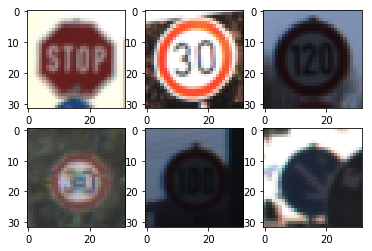

In [14]:
## Visualize random images
N_example_images = 6
columns = 3
rows = N_example_images//columns

fig, ax = plt.subplots(rows, columns)


for row in ax:
    for col in row:
        index = randint(0, n_train)
        col.imshow(X_train[index,:])


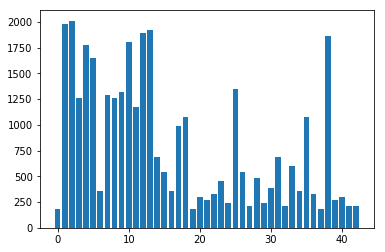

In [10]:
## Visualize data distribution

classes, repeat = np.unique(y_train,return_counts=True)

plt.bar(classes, repeat)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [24]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
# X_train = (X_train - 128)/128
# X_valid = (X_valid - 128)/128

### Model Architecture

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


In [36]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def conv2d(x, W, b, strides=1,padding="VALID"):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

## Architecture
* Inputs: 3 filtros (RGB)
* Capa Convolucional: 16 filtros, kernel 5x5, padding 'same', funcion de activacion ELU
* Capa Convolucional: 32 filtros, kernel 3x3, padding 'same', stride 2, funcion de activacion ELU
* Capa Convolucional: 64 filtros, kernel 3x3, padding 'same', stride 2, funcion de activacion ELU
* Capa Convolucional: 64 filtros, kernel 3x3, padding 'same', funcion de activacion ELU
* Flatten: se aplana a vector
* Capa Densa: 1024 neuronas, activacion ELU, dropout = 0.5
* Capa Densa: 512 neuronas, activacion ELU
* Capa Densa Output: 43 neuronal, activacion softmax

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [10]:
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.001

In [1]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [40]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

In [41]:
logits = ChNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [42]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.116

EPOCH 2 ...
Validation Accuracy = 0.173

EPOCH 3 ...
Validation Accuracy = 0.282



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")